# Clustering

Here used origin [Backblaze data](https://www.backblaze.com/b2/hard-drive-test-data.html) from 2019y Q1-Q2.

In [16]:
import pandas as pd
import glob

# Concatenating all datasets (one dataset per month 2017) to one
##df_bb = pd.concat(map(pd.read_csv, glob.glob("./backblaze_ST4000DM000/*.csv")))
df = pd.concat(map(pd.read_csv, glob.glob("backblaze2019/2019-0[1-4]*.csv")))
df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2019-01-01,Z305B2QN,ST4000DM000,4000787030016,0,111.0,35673128.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,ZJV0XJQ4,ST12000NM0007,12000138625024,0,83.0,187116872.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,ZJV0XJQ3,ST12000NM0007,12000138625024,0,73.0,19599104.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,ZJV0XJQ0,ST12000NM0007,12000138625024,0,81.0,136943696.0,NaN,NaN,93.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,0,100.0,0.0,134.0,103.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df.shape

(12749797, 129)

## Preparing data

In [18]:
df1 = df[df['model'] == "ST12000NM0007"]
df1.shape

(3995952, 129)

In [19]:
#df1 = df1[df1.serial_number.duplicated(keep=False)]

# we consider time series with less than 5 elements for failed disks as unpredictable
df1 = df1[df1.groupby('serial_number').serial_number.transform('count') > 5]

In [20]:
df1.shape

(3995848, 129)

In [21]:
df1['serial_number'].value_counts()

ZJV0XJQ4    120
ZJV121RE    120
ZJV121R2    120
ZJV137XC    120
ZJV121R8    120
           ... 
ZCH0CZ83      6
ZCH01CMS      6
ZCH01EXE      6
ZCH07H2T      6
ZJV27P1E      6
Name: serial_number, Length: 34943, dtype: int64

In [22]:
# take only several health disks for learning
health_data = df1[df1.groupby('serial_number').serial_number.transform('count')  == 120]
health_data = health_data[health_data['failure'] == 0]
serial_numbers_to_stay = health_data['serial_number'].unique()[:300]
health_data = health_data[health_data['serial_number'].isin(serial_numbers_to_stay)]
health_data.shape
df1 = health_data

In [23]:
df1['serial_number'].value_counts()

ZJV0XJQ4    120
ZJV0WG22    120
ZJV0WG29    120
ZJV136WZ    120
ZJV136WV    120
           ... 
ZCH06FNZ    120
ZJV109HZ    120
ZJV1C4CL    120
ZJV2ES4K    120
ZCH07JB1    120
Name: serial_number, Length: 300, dtype: int64

In [24]:
df1.select_dtypes(include='object')

,date,serial_number,model
1,2019-01-01,ZJV0XJQ4,ST12000NM0007
2,2019-01-01,ZJV0XJQ3,ST12000NM0007
3,2019-01-01,ZJV0XJQ0,ST12000NM0007
6,2019-01-01,ZJV02XWG,ST12000NM0007
7,2019-01-01,ZJV1CSVX,ST12000NM0007
...,...,...,...
88956,2019-04-30,ZJV03R6X,ST12000NM0007
90258,2019-04-30,ZCH07JB8,ST12000NM0007
97749,2019-04-30,ZJV0TEHK,ST12000NM0007
98723,2019-04-30,ZCH06F8R,ST12000NM0007


In [25]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df1['serial_number'])
le.classes_
df1['serial_number'] = le.transform(df1['serial_number'])

In [26]:
le.fit(df1['date'])
le.classes_
df1['date'] = le.transform(df1['date'])

In [27]:
df1 = df1.drop(['model'], axis=1)

In [28]:
# drop all columns which have only NAN values
df1 = df1.dropna(axis=1, how='all')
df1.shape

(36000, 48)

In [29]:
df1 = df1.dropna()
df1.shape

(35997, 48)

In [30]:
y1 = df1['failure']
X = df1.drop('failure',axis=1)

In [31]:
X['serial_number'].value_counts()

251    120
221    120
268    120
267    120
266    120
      ... 
235    120
164    120
256    119
281    119
39     119
Name: serial_number, Length: 300, dtype: int64

In [32]:
y1.value_counts()

0    35997
Name: failure, dtype: int64

## PCA 

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,0.0,0.839465,0.0,0.527778,0.766465,0.916667,0.0,0.0,0.028571,0.0,...,0.0,0.0,0.0,0.0,0.0,0.209215,0.0,0.424055,0.0,0.119873
1,0.0,0.836120,0.0,0.250000,0.080276,1.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.029056,0.0,0.082167,0.0,0.002668
2,0.0,0.832776,0.0,0.472222,0.560945,0.500000,0.0,0.0,0.142857,0.0,...,0.0,0.0,0.0,0.0,0.0,0.297071,0.0,0.493713,0.0,0.219711
3,0.0,0.575251,0.0,0.472222,0.477300,0.416667,0.0,0.0,0.142857,0.0,...,0.0,0.0,0.0,0.0,0.0,0.400261,0.0,0.516849,0.0,0.257572
4,0.0,0.929766,0.0,0.500000,0.702213,0.916667,0.0,0.0,0.028571,0.0,...,0.0,0.0,0.0,0.0,0.0,0.280435,0.0,0.521600,0.0,0.230047


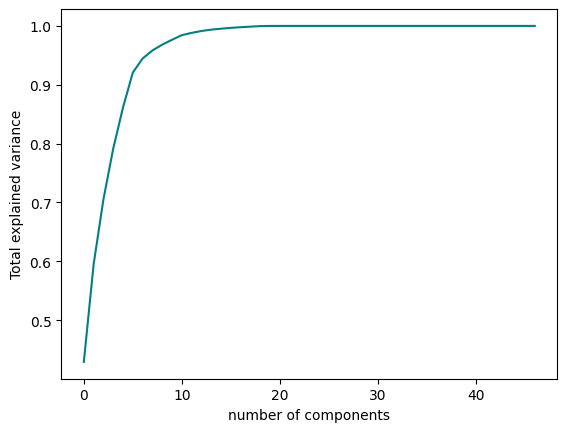

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pca = PCA().fit(df_scaled) 
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='teal') 
plt.xlabel('number of components') 
plt.ylabel('Total explained variance'); 

In [35]:
pca = PCA(0.80).fit(df_scaled)
pca.n_components_ 

5

In [36]:
pca = PCA(0.95).fit(df_scaled)
pca.n_components_ 

8

## Визуализация кластеров полученных снижением размерности с помощью PCA

In [37]:
pca = PCA(n_components=2)
pca.fit(df_scaled)
X_pca = pca.transform(df_scaled)

In [38]:
df_pca = pd.DataFrame(X_pca, columns =['Component 1', 'Component 2'])
df_pca.head(2)

,Component 1,Component 2
0,0.833897,-0.357438
1,1.255780,0.677530


In [39]:
y1.reset_index(inplace=True, drop=True)
y1

0        0
1        0
2        0
3        0
4        0
        ..
35992    0
35993    0
35994    0
35995    0
35996    0
Name: failure, Length: 35997, dtype: int64

In [40]:
df_pca = pd.concat([df_pca, y1], axis=1)
df_pca.head()

,Component 1,Component 2,failure
0,0.833897,-0.357438,0
1,1.255780,0.677530,0
2,0.569353,-0.067698,0
3,0.260942,0.034382,0
4,0.728886,-0.255320,0


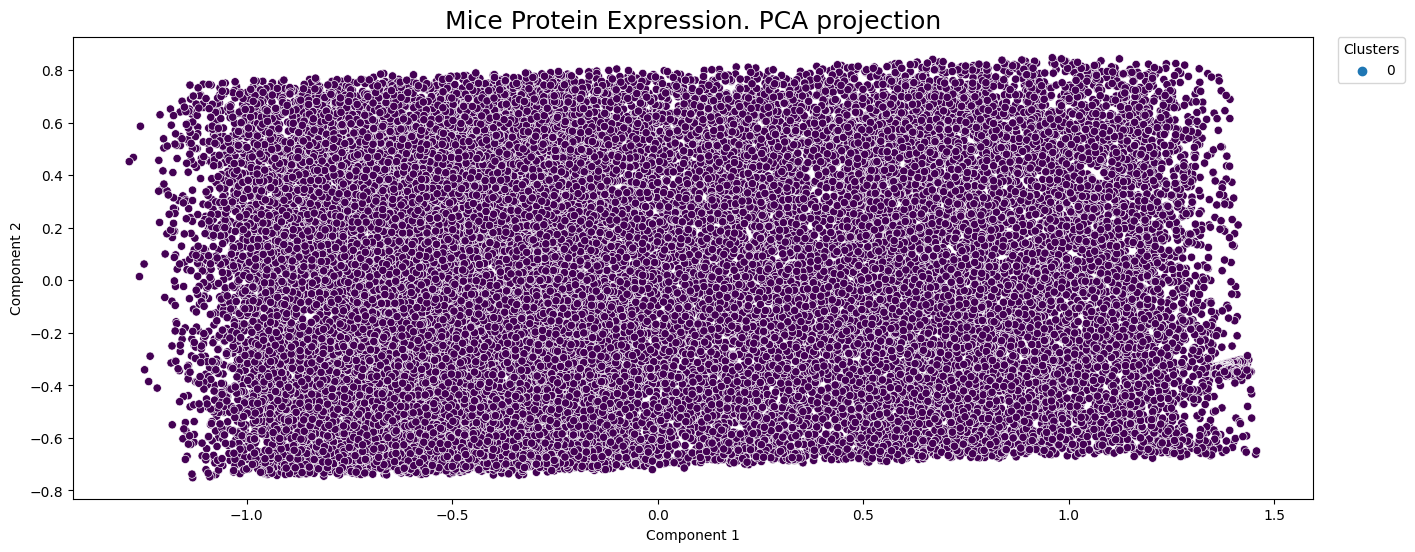

In [41]:
plt.figure(figsize=(16, 6)) 

sns.scatterplot(x = 'Component 1', y = 'Component 2', data = df_pca, c=y1, hue = 'failure')
plt.title('Mice Protein Expression. PCA projection', fontsize=18)
plt.legend(title='Clusters', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize='medium')

plt.show()


## Подбор гиперпараметров

In [42]:
from sklearn.decomposition import PCA

components = [4, 7]
X_reduced = []
for reduced_dims in components:
    pca = PCA(n_components=reduced_dims)
    X_transformed = pca.fit_transform(df_scaled)
    X_reduced.append(X_transformed)

In [43]:
import pathlib
import itertools
import time
from sklearn.base import clone
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score

RESULTS_PATH = pathlib.Path("cv_results.csv")


def train_and_store(estimator, param_grid: dict | None = None):
    param_grid = param_grid if param_grid is not None else {}
    param_combs = [
        dict(params) for params in
        itertools.product(
            *([(name, v) for v in vs] for (name, vs) in param_grid.items())
        )
    ]

    results = []
    for X in X_reduced:
        best_ari = None
        best_ami = None
        best_fmi = None

        for params in param_combs:
            cloned_estimator = clone(estimator).set_params(**params)

            start_t = time.perf_counter()
            pred = cloned_estimator.fit_predict(X)
            fit_predict_time_s = (time.perf_counter() - start_t)

            ari = adjusted_rand_score(y1, pred)
            if best_ari is None or ari > best_ari[0]:
                best_ari = ari, fit_predict_time_s, params

            ami = adjusted_mutual_info_score(y1, pred)
            if best_ami is None or ami > best_ami[0]:
                best_ami = ami, fit_predict_time_s, params

            fmi = fowlkes_mallows_score(y1, pred)
            if best_fmi is None or fmi > best_fmi[0]:
                best_fmi = fmi, fit_predict_time_s, params

        print(
            f"Best params for {X.shape[1]}:",
            f"By ARI: {best_ari[2]}",
            f"By AMI: {best_ami[2]}",
            f"By FMI: {best_fmi[2]}",
            "",
            sep="\n",
        )

        results.append(
            {
                "Clusterer": estimator.__class__.__name__,
                "Input dimension": X.shape[1],
                "fit_predict time, s": np.mean([best_ari[1], best_ami[1], best_fmi[1]]),
                "ARI": best_ari[0],
                "AMI": best_ami[0],
                "FMI": best_fmi[0],
            }
        )

    pd.DataFrame(results).to_csv(RESULTS_PATH, mode="a", header=not RESULTS_PATH.exists())

## KMeans

In [44]:
from sklearn.cluster import KMeans

model = KMeans(random_state=42)
hyper_parameters = {
        "algorithm": ["lloyd", "elkan"],
        "max_iter": [100, 200, 300],
        "n_clusters": range(2,10)
    }

kmeans_results = train_and_store(model, hyper_parameters)
kmeans_results

Best params for 4:
By ARI: {'algorithm': 'lloyd', 'max_iter': 100, 'n_clusters': 2}
By AMI: {'algorithm': 'lloyd', 'max_iter': 100, 'n_clusters': 2}
By FMI: {'algorithm': 'lloyd', 'max_iter': 100, 'n_clusters': 2}

Best params for 7:
By ARI: {'algorithm': 'lloyd', 'max_iter': 100, 'n_clusters': 2}
By AMI: {'algorithm': 'lloyd', 'max_iter': 100, 'n_clusters': 2}
By FMI: {'algorithm': 'lloyd', 'max_iter': 100, 'n_clusters': 2}



## Agglomerative clustering

In [45]:
from sklearn.cluster import AgglomerativeClustering

model_agc = AgglomerativeClustering()

hyper_parameters = {
    "n_clusters": [10, 20, 50, 100, 300],
    "affinity": ["cityblock", "cosine", "l1", "l2", "manhattan"],
    "linkage": ["complete", "average"],
}

train_and_store(model_agc, hyper_parameters)

Best params for 4:
By ARI: {'n_clusters': 10, 'affinity': 'cityblock', 'linkage': 'complete'}
By AMI: {'n_clusters': 10, 'affinity': 'cityblock', 'linkage': 'complete'}
By FMI: {'n_clusters': 10, 'affinity': 'cosine', 'linkage': 'average'}

Best params for 7:
By ARI: {'n_clusters': 10, 'affinity': 'cityblock', 'linkage': 'complete'}
By AMI: {'n_clusters': 10, 'affinity': 'cityblock', 'linkage': 'complete'}
By FMI: {'n_clusters': 10, 'affinity': 'cityblock', 'linkage': 'average'}



## DBSCAN

In [ ]:
%%time
from sklearn.cluster import DBSCAN

model_dbscan = DBSCAN(n_jobs=-1)
hyper_parameters ={
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "metric": ["cityblock", "l1", "l2", "manhattan"],
}

train_and_store(model_dbscan, hyper_parameters)

Best params for 4:
By ARI: {'algorithm': 'auto', 'metric': 'cityblock'}
By AMI: {'algorithm': 'auto', 'metric': 'cityblock'}
By FMI: {'algorithm': 'auto', 'metric': 'cityblock'}



## Bisecting KMeans

In [ ]:
from sklearn.cluster import BisectingKMeans

bisect_kmeans = BisectingKMeans(random_state=0)

hyper_parameters = {
        "algorithm": ["lloyd", "elkan"],
        "max_iter": [1000, 5000, 10000],
        "n_clusters": [20, 30, 40]
}

bkmeans_results = train_and_store(bisect_kmeans, hyper_parameters)
bkmeans_results